In [1]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net, SCVIZ_CheckNet2Net
import pickle5
from tqdm import tqdm 
from sklearn.neighbors import NearestNeighbors
from perturbnet.baselines.knn import *

from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
some_path = ""
path_cinn_model =  "/nfs/turbo/umms-welchjd/wzqian/model_save/ursu/holdout1" + '/cinn/50ep/'
path_data = "/nfs/turbo/umms-welchjd/wzqian/data/benchmark_dataset_save/ursu/"
path_scvi_model_train = "/nfs/turbo/umms-welchjd/wzqian/model_save/ursu/holdout1" + '/cellvae/700ep/model/' 

# Load Data and PerturbNet

In [6]:
#some_path = ""
#path_cinn_model =  some_path + '/cinn/50ep/'
#path_data = ""
#path_scvi_model_train = some_path + '/cellvae/700ep/model/' 

    
adata = ad.read_h5ad(os.path.join(path_data, "ursu_400filter_standard.h5ad"))

adata_save_index = np.array(adata.obs[adata.obs["variant_seq_use"] == "Yes"].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index(drop = True)

adata_save_index = np.array(adata.obs[adata.obs["if_control"] != "Wild Type Like"].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index(drop = True)
    
#scvi.data.setup_anndata(adata, layer = "counts")
adata_test_index = np.array(adata.obs[adata.obs["1st_hengshi_holdout"] == "test"].index).astype(int)
adata_test = adata[adata_test_index, :].copy()
    
adata_train_index = np.array(adata.obs[adata.obs["1st_hengshi_holdout"] == "train"].index).astype(int)
adata_train = adata[adata_train_index, :].copy()

scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model_cinn = scvi.model.SCVI.load(path_scvi_model_train, adata_train, use_cuda = False)
    
perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["variant_seq"]), np.array(adata_test.obs["variant_seq"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    

onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_trt"] == trt)[0][0]
    
    onehot_unseen_idx.append(onehot_idx)
    unseen_onehot = adata.uns["ordered_all_embedding"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_trt"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
    seen_onehot = adata.uns["ordered_all_embedding"][onehot_seen_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

perturbToEmbed = {}
for i in range(trt_obs_list.shape[0]):
    perturbToEmbed[trt_obs_list[i]] = i
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=1280,embedding_dim=10,conditioning_depth=2,n_flows=20,in_channels=10,hidden_dim=1024,
hidden_depth=2,activation="none",conditioner_use_bn=True)

model_c = Net2NetFlow_scVIFixFlow(configured_flow = flow_model,
                                 cond_stage_data = perturb_with_onehot_kept,
                                perturbToEmbedLib = perturbToEmbed,
                                  embedData = seen_onehot,
                                     scvi_model = scvi_model_cinn)

(156632, 17)
(133231, 17)
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 123653 cells, 1629 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batc

In [9]:
model_c.to(device = device)
model_c.load(path_cinn_model)
model_c.eval()
scvi_model_de = scvi_predictive_z(scvi_model_cinn)
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)
if sparse.issparse(adata_test.X):
    usedata = adata_test.X.A
else:
    usedata = adata_test.X

if sparse.issparse(adata_test.layers["counts"]):
    usedata_count = adata_test.layers["counts"].A
else:
    usedata_count = adata_test.layers["counts"]

fidscore_cal = fidscore()

normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)
Lsample_obs = scvi_model_cinn.get_latent_library_size(adata = adata_train, give_mean = False)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

In [10]:
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
fid_mu = []
fid_sample = []
pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type  =  np.random.choice(idx_trt_type, 1000, replace = False)
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), 500, replace=True)
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1))



    trt_onehot = onehot_indice_trt + np.random.normal(scale = 0.001, size = onehot_indice_trt.shape)
    library_trt_latent =Lsample_obs[Lsample_idx]

    _, fake_data = perturbnet_model.sample_data(trt_onehot, library_trt_latent)
    real_data = usedata_count[idx_trt_type]
    r2_value, real_norm, rfake_norm = normModel.calculate_r_square(real_data, fake_data)
    pear_value = normModel.calculate_pearson(real_data, fake_data)

        

    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = normModel.calculate_pearson(real_data_deg, fake_data_deg)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value,_ ,_  = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })

100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


# Training Sample

In [11]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
fid_mu = []
fid_sample = []
pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    seen_data = adata_train.layers["counts"].A
    seen_data_idx = list(range(seen_data.shape[0]))

    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    idx_rsample = np.random.choice(seen_data_idx, len(real_data_idx), replace=True)
    fake_data = seen_data[idx_rsample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_rsample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)

    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

    
results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


# KNN

In [12]:
neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(seen_onehot)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
seen_data_idx = list(range(seen_data.shape[0]))

for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]

    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    distances, other_trts = neigh_fit.kneighbors(unseen_onehot[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(real_data_idx))
    
    fake_data = seen_data[idx_sample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_sample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

    
results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 12/12 [00:01<00:00,  6.05it/s]


In [13]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
peardeg = []
pear_large = []

np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
mean_seen = np.mean(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    seen_data = adata_train.layers["counts"].A
    seen_data_idx = list(range(seen_data.shape[0]))
    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    fake_data = np.tile(mean_seen,(len(real_data_idx),1))
    
    r2_value,_,_ = normModel.calculate_r_square(real_data, fake_data)
    r2pear_value = normModel.calculate_pearson(real_data, fake_data)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    r2pear_deg = normModel.calculate_pearson(real_data_deg, fake_data_deg)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value,_,_ = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(r2pear_value)
    peardeg.append(r2pear_deg)
    pear_large.append(pear_large_value)

    
results_mean = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,
                        "r2_deg":r2_deg, "pear_deg":peardeg, 
                        "r2_large":r2_large,"pear_large": pear_large
                       })

### median model

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
peardeg = []
pear_large = []


np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
median_seen = np.median(seen_data,axis = 0)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    seen_data = adata_train.layers["counts"].A
    seen_data_idx = list(range(seen_data.shape[0]))
    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    fake_data = np.tile(median_seen,(len(real_data_idx),1))
    
    r2_value,_,_ = normModel.calculate_r_square(real_data, fake_data)
    r2pear_value = normModel.calculate_pearson(real_data, fake_data)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    r2pear_deg = normModel.calculate_pearson(real_data_deg, fake_data_deg)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value,_,_ = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)

    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(r2pear_value)
    peardeg.append(r2pear_deg)
    pear_large.append(pear_large_value)

    
results_median = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,
                        "r2_deg":r2_deg, "pear_deg":peardeg, 
                        "r2_large":r2_large,"pear_large": pear_large
                       })


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


# Linear

In [17]:
expanded_seen_embeddings = []
for indice_trt in tqdm(range(len(trt_obs_list))):
    trt_type = trt_obs_list[indice_trt ]
    idx_trt_type = np.where(perturb_with_onehot_kept == trt_type)[0]
    onehot_indice_trt = np.tile(seen_onehot[[indice_trt]], (len(idx_trt_type), 1))  
    trt_onehot = onehot_indice_trt + np.random.normal(scale = 0.001, size = onehot_indice_trt.shape)
    expanded_seen_embeddings.append(trt_onehot )
expanded_seen_embeddings = np.vstack(expanded_seen_embeddings)
X_train = expanded_seen_embeddings
Y_train = adata_train.X
ridge = Ridge(alpha=0.1)  
ridge.fit(X_train, Y_train)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
peardeg = []
pear_large = []
np.random.seed(2023)
fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]

    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().X
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1))
    trt_onehot = onehot_indice_trt + np.random.normal(scale = 0.001, size = onehot_indice_trt.shape)
    fake_data =  ridge.predict(trt_onehot  )
    
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    r2pear_value  = fidscore_cal.calculate_pearson(real_data, fake_data)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    r2pear_deg = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(r2pear_value)
    peardeg.append(r2pear_deg)
    pear_large.append(pear_large_value) 
    
    
results_linear = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,
                        "r2_deg":r2_deg, "pear_deg":peardeg, 
                        "r2_large":r2_large,"pear_large": pear_large
                       })

100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


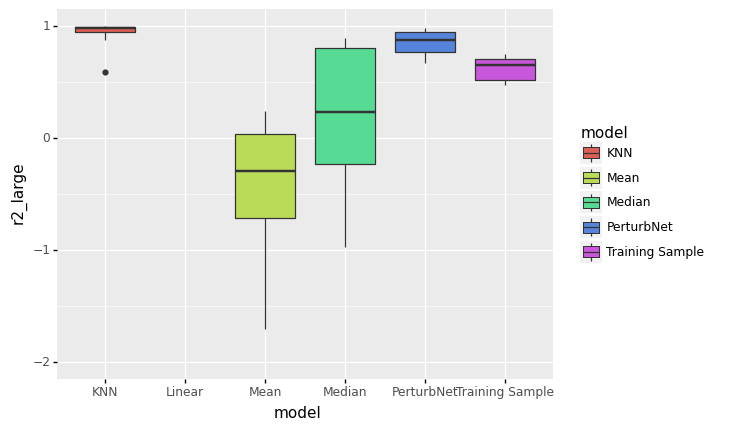

<ggplot: (1396985157949)>

In [18]:
from plotnine import ylim
boxplot_metrics({"PerturbNet":results_PerturbNet,  "Training Sample":results_sample,
                "KNN": results_KNN,"Mean":results_mean, "Median":results_median, "Linear":results_linear  }, metric_key = "r2_large") + ylim((-2, 1.0))